## Bead-Spring Polymer VAE

This polymer has each bead (atom) joined by a harmonic bond, a harmonic angle between each three, and a Lennard-Jones interaction potential. Knowing these items will not be necessary for the example. Each of our data points below will be the x and y coordinates of 12 beads. We'll construct a VAE that can compress the trajectory to some latent space and generate new conformations.

Since we're now work with continuous features $x$. We need to make a few key changes. The encoder will remain the same, but the decoder now must output a $p_\theta(x | z)$ that gives a probability to all possible $x$ values. Above, we only had a finite number of classes but now any $x$ is possible. As we did for the encoder, we'll assume that $p_\theta(x | z)$ should be normal and we'll output the parameters of the normal distribution from our network. This requires an update to the reconstruction loss to be a log of a normal, but otherwise things will be identical.

Don't worry about this too much but a small detail is that the log-likelihood for a normal distribution with a single observation cannot have unknown standard deviation. Our new normal distribution parameters for the decoder will have a single observation for a single $x$ in training. If you make the standard deviation trainable, it will just pick infinity as the standard deviation since that will for sure capture the point and you only have one point. Thus, we'll make the decoder standard deviation be a hyperparameter. We don't see this issue with the encoder, which also outputs a normal distribution, because we training the encoder with the KL-divergence term and not likelihood of observations (reconstruction loss).

To begin, we'll need to align points from a trajectory in order to ensure the data is translationally and rotationally invariant. This will then serve as our training data. The space of our problem will be 12 2D vectors. Our system need not be permutation invariant, so we can flatten these vectors into a 24 dimensional input. The code belows loads and aligns the trajectory


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn, torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The dataset consists of a molecular dynamics trajectory of a simple 12-bead polymer chain in 2D space. Each frame in the trajectory represents one conformation of the polymer and contains the x and y coordinates of all 12 beads.

Each data point has the shape: [12 beads, 2 coordinates]

The data array is [N, 12 beads, 2 coordinates]

In [7]:
# import data
url = "https://github.com/whitead/dmol-book/raw/main/data/long_paths.npz"
urllib.request.urlretrieve(url, "paths.npz")
xyz = np.load("paths.npz")["arr"]          # (Nframes, Natoms, 2)

In [8]:
###---------Transformation Functions----###
# for rotational/translational invariance

# helper: centring + PCA alignment (identical to dmol.pub helpers)
def center_com(x):                         # centre each frame at COM
    return x - x.mean(1, keepdims=True)

def align_principle(x):                    # align principal axis per frame
    R = []
    for frame in x:
        u, _, _ = np.linalg.svd(frame.T @ frame)
        R.append(frame @ u)                # rotate
    return np.stack(R)

data = align_principle(center_com(xyz))    # (N, A, 2)

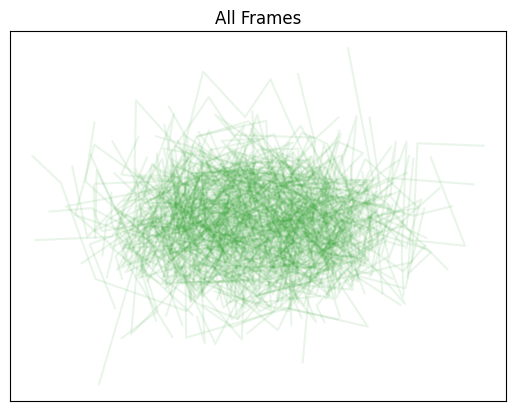

In [9]:
# visualize all the data
cmap = plt.get_cmap("cool")
for i in range(0, data.shape[0], 16):
    plt.plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C2")
plt.title("All Frames")
plt.xticks([])
plt.yticks([])
plt.show()

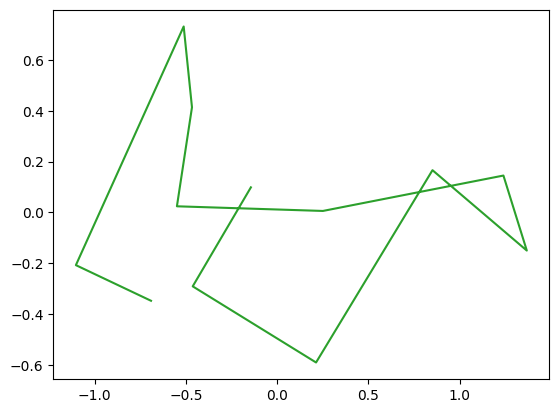

In [10]:
# visualize a single data point
plt.plot(data[3, :, 0], data[3, :, 1], "-", color="C2")

Before training, let’s examine some of the marginals of the data to visualize the data. Marginals mean we’ve transformed (by integration) our probability distribution to be a function of only 1-2 variables so that we can plot nicely. We’ll look at the pairwise distance between beads (beads are indexed 0-11).

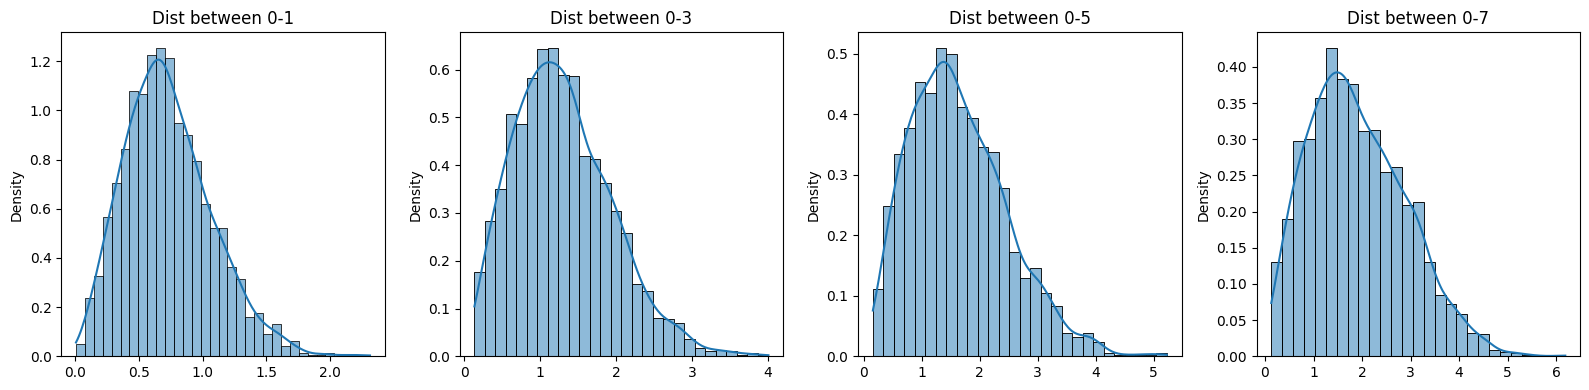

In [11]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.histplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i], kde=True, stat="density")
plt.tight_layout()

In [ ]:
# prepare the input

X = data.reshape(len(data), -1).astype("float32")
input_dim = X.shape[1]

tensorX = torch.tensor(X).to(device)
loader  = DataLoader(TensorDataset(tensorX), batch_size=256, shuffle=True)

These look a little like the chi distribution with two degrees of freedom. Notice that the support (x-axis) changes between them though. We’ll keep an eye on these when we evaluate the efficacy of our VAE.

### VAE Model

Now we'll build the VAE similar to before.

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 2.  Simple fully-connected VAE (latent_dim = 2 for plotting)
# ─────────────────────────────────────────────────────────────────────────────
class Encoder(nn.Module):
    def __init__(self, in_dim, hid, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, hid)
        self.fc_mu = nn.Linear(hid, z_dim)
        self.fc_lv = nn.Linear(hid, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_lv(h)

class Decoder(nn.Module):
    def __init__(self, in_dim, hid, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hid)
        self.fc2 = nn.Linear(hid, hid)
        self.out = nn.Linear(hid, in_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return self.out(h)                 # no activation → real coords

class VAE(nn.Module):
    def __init__(self, in_dim, hid=128, z_dim=2):
        super().__init__()
        self.enc, self.dec = Encoder(in_dim, hid, z_dim), Decoder(in_dim, hid, z_dim)
        self.beta = 1.0

    @staticmethod
    def reparam(mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5*logvar)

    def forward(self, x):
        mu, lv = self.enc(x)
        z = self.reparam(mu, lv)
        recon = self.dec(z)
        return recon, mu, lv


### Loss

The loss function is similar to above, but I will not bother sampling from the decoded distribution, and instead just take the value outputted from the decoder. You can see the only change is that we drop the output Gaussian standard deviation from the loss, which remember was not trainable anyway.

In [ ]:
def vae_loss(x_rec, x, mu, lv, beta):
    recon = F.mse_loss(x_rec, x, reduction='mean')         # continuous coords
    kl = -0.5 * torch.mean(1 + lv - mu.pow(2) - lv.exp())
    return recon + beta*kl, recon, kl



In [ ]:
model = VAE(input_dim).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 3.  Train for 10 epochs with a 5-epoch β warm-up
# ─────────────────────────────────────────────────────────────────────────────
ramp = 5
hist = {"recon":[], "kl":[]}

for epoch in range(10):
    model.beta = min(1.0, epoch / ramp)
    recon_ep = kl_ep = 0.
    for xb in loader: # Remove the comma and underscore to only unpack one value.
        rec, mu, lv = model(xb[0])
        loss, r, k  = vae_loss(rec, xb[0], mu, lv, model.beta) # Change xb to xb[0] to access the data tensor.
        opt.zero_grad(); loss.backward(); opt.step()
        recon_ep += r.item(); kl_ep += k.item()
    recon_ep /= len(loader); kl_ep /= len(loader)
    hist["recon"].append(recon_ep); hist["kl"].append(kl_ep)
    print(f"ep {epoch:02d}  β={model.beta:.2f}  recon={recon_ep:.4f}  KL={kl_ep:.4f}")

ep 00  β=0.00  recon=0.2637  KL=0.0308
ep 01  β=0.20  recon=0.1372  KL=0.0670
ep 02  β=0.40  recon=0.1149  KL=0.0091
ep 03  β=0.60  recon=0.1035  KL=0.0047
ep 04  β=0.80  recon=0.0997  KL=0.0017
ep 05  β=1.00  recon=0.0975  KL=0.0008
ep 06  β=1.00  recon=0.0966  KL=0.0004
ep 07  β=1.00  recon=0.0961  KL=0.0002
ep 08  β=1.00  recon=0.0958  KL=0.0001
ep 09  β=1.00  recon=0.0957  KL=0.0000


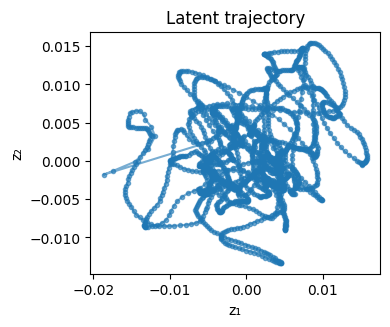

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 4.  Plot latent trajectory of the **raw MD frames**
# ─────────────────────────────────────────────────────────────────────────────
with torch.no_grad():
    mu,_ = model.enc(tensorX)
Z = mu.cpu().numpy()                       # (Nframes, 2)

plt.figure(figsize=(4,4))
plt.plot(Z[:,0], Z[:,1], "-o", alpha=.6, markersize=3)
plt.title("Latent trajectory"); plt.xlabel("z₁"); plt.ylabel("z₂")
plt.gca().set_aspect("equal"); plt.tight_layout(); plt.show()

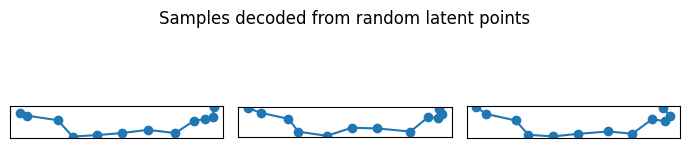

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 5.  Generate *new* conformations from random z and visualise one
# ─────────────────────────────────────────────────────────────────────────────
with torch.no_grad():
    z = torch.randn(16, 2, device=device)
    new_xyz = model.dec(z).cpu().numpy().reshape(16, -1, 2)

fig, ax = plt.subplots(1,3, figsize=(7,2))
for i in range(3):
    frame = new_xyz[i]
    ax[i].plot(frame[:,0], frame[:,1], 'o-')
    ax[i].set_xticks([]); ax[i].set_yticks([]); ax[i].set_aspect('equal')
plt.suptitle("Samples decoded from random latent points"); plt.tight_layout(); plt.show()